# Setting up a latent function Gaussian Process for H(z)

In [1]:
# import set 1
using Turing
using Distances
using LinearAlgebra
using LimberJack

In [2]:
# import set 2
using Interpolations
using GaussianProcess
using Plots
using QuadGK
using BlockDiagonals

### Collate data

In [3]:
# setting a cosmology for the fake data 
cosmo1 = Cosmology();

#### Hz data

In [4]:
function fakedata_hz()
z  = sort(2.5 .* rand(30)) # random array of 30 z values sorted ascending (0 - 2.5)
data  = cosmo1.cpar.h*100*Ez(cosmo1, z)
err = 0.1 .* data
cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "fakedata_hz", z = z, data = data, cov = cov)
end

fakedata_hz (generic function with 1 method)

#### Dm data

In [5]:
function fakedata_dm()
    z = sort(2.5 .* rand(300))
    data = cosmo1.chi(z)
    err = 0.1 .* data
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "fakedata_dm", z = z, data = data, cov = cov)
end

fakedata_dm (generic function with 1 method)

#### fs8 data

In [6]:
function fakedata_fs8()
    z = sort([[0.01, 0.02, 0.07] ; (2.5 .* rand(20))])
    data = fs8(cosmo1, z)
    err = 0.1 .* data
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return(data_name = "fakedata_fs8", z = z, data = data, cov = cov)
end

fakedata_fs8 (generic function with 1 method)

#### Putting Hz, Dm and fs8 data together

In [7]:
fakedatahz = fakedata_hz();
fakedatadm = fakedata_dm();
fakedatafs8 = fakedata_fs8();

In [8]:
# fake data
data_obs  = [fakedatahz.data; fakedatadm.data; fakedatafs8.data];
z_obs = [fakedatahz.z; fakedatadm.z; fakedatafs8.z];
covariance_obs = BlockDiagonal([fakedatahz.cov, fakedatadm.cov, fakedatafs8.cov]);

In [ ]:
# errors
hz_err = 0.1 .* fakedatahz.data;
dm_err = 0.1 .* fakedatadm.data;
fs8_err = 0.1 .* fakedatafs8.data;

23-element Vector{Float64}:
 0.03659747672984192
 0.03678458300532287
 0.037397925451011546
 0.037470653756859304
 0.037597486851292675
 0.038970282958469965
 0.03773639313625926
 0.03695303016818619
 0.0351670532629353
 0.03356138683568328
 ⋮
 0.016667004624727196
 0.015590480079958908
 0.011083517732595097
 0.01061467165594296
 0.00958307660820908
 0.007559165380051771
 0.0031023831986825984
 0.0028083164870396555
 0.0009376022542716515

### Functions for hz, chi and fs8

In [10]:
function hubble_param(zarr, h0, ez)
    ez_itp = linear_interpolation(zarr, ez, extrapolation_bc=Line())
    hz = ez_itp(zarr) .* (h0*100)
    #hzi = linear_interpolation(zarr, hz, extrapolation_bc=Line())
    return hz
end

hubble_param (generic function with 1 method)

In [11]:
function comoving_d(zs, h0, ez)
    # AD-safe interpolation
    itp = interpolate((zs,), ez, Gridded(Linear()))
    ez_itp = extrapolate(itp, Line())

    # Use correct element type (Dual-friendly)
    chis = zeros(eltype(ez), length(zs))

    for i in eachindex(zs)
        zz = zs[i]
        f(z) = 1.0 / max(ez_itp(z), 1e-12)   # stable integrand
        chis[i] = quadgk(f, 0.0, zz, rtol=1e-5)[1]
        chis[i] *= LimberJack.CLIGHT_HMPC / h0
    end

    return chis
end


comoving_d (generic function with 1 method)

In [12]:
function comoving_d2(zs, h0, ez)
    ez_itp = linear_interpolation(zs, ez, extrapolation_bc=Line())
    chis = zeros(eltype(ez), length(zs))
    for i in 1:length(zs)
        zz = zs[i]
        chis[i] = quadgk(z -> 1.0/ez_itp(z), 0.0, zz, rtol=1E-5)[1]
        chis[i] *= LimberJack.CLIGHT_HMPC / h0
    end
    #chii = linear_interpolation(zs, vec(chis), extrapolation_bc=Line())

    return chis
end


comoving_d2 (generic function with 1 method)

In [13]:
function get_growth3(zarr, Ωm, σ8, h0, cosmo_type, e)
    nz2 = length(zarr)
    z_max = maximum(zarr)
    x = LinRange(0, log(1+z_max), nz2)
    z = @.(exp(x) - 1)
    a = @.(1/(1+z))
    dx = x[2]-x[1]
    
    aa = reverse(a)
    ee = reverse(e)
    dd = zeros(cosmo_type, nz2)
    yy = zeros(cosmo_type, nz2)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]
    
    for i in 1:(nz2-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx*yy[i] + (1+0.5*dx^2*A0*B0)*dd[i]
    end
    
    y = reverse(yy)
    d = reverse(dd)

    fs8zi =  -σ8 .* y./ (a.^2 .*e.*d[1])
                                
                        
    return fs8zi
end

get_growth3 (generic function with 1 method)

## LCDM analysis

In [14]:
z_integ1 = range(0, 3.0, length=100);

In [15]:
@model function LCDM_model(data, data_cov)
    # Priors
    omegam_pr ~ Uniform(0.1, 0.5)
    h0_pr ~ Uniform(0.6, 0.8)
    s8_pr ~ Uniform(0.6, 0.9)

    # Create cosmology
    #cosmo_pr = LimberJack.Cosmology(Ωm=cosmo1.cpar.Ωm, Ωb=cosmo1.cpar.Ωb, h=cosmo1.cpar.h, σ8=cosmo1.cpar.σ8);
    cosmo_pr = LimberJack.Cosmology(Ωm=cosmo1.cpar.Ωm, Ωb=cosmo1.cpar.Ωb, h=cosmo1.cpar.h, σ8=s8_pr);
    # # Model predictions
    ez_model = Ez(cosmo_pr, z_integ1)
    hz_model = hubble_param(z_integ1, h0_pr, ez_model)
    dm_model = comoving_d(z_integ1, h0_pr, ez_model)
    fs8_model = get_growth3(z_integ1, omegam_pr, s8_pr, h0_pr, eltype(ez_model), ez_model)

    hz_itp = LinearInterpolation(z_integ1, hz_model, extrapolation_bc=Line())
    dm_itp = LinearInterpolation(z_integ1, dm_model, extrapolation_bc=Line())
    fs8_itp = LinearInterpolation(z_integ1, fs8_model, extrapolation_bc=Line())

    hz_theory := hz_itp(fakedatahz.z)
    dm_theory := dm_itp(fakedatadm.z)
    fs8_theory := fs8_itp(fakedatafs8.z)

    theory = [hz_theory;dm_theory;fs8_theory]

    # # Likelihood
    data = MvNormal(theory, data_cov)
end

LCDM_model (generic function with 2 methods)

In [16]:
cond_LCDM_model = LCDM_model(data_obs, covariance_obs)
chain_LCDM = sample(cond_LCDM_model, NUTS(20, 0.65), 100)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference /Users/vis/.julia/packages/Turing/QN7BL/src/mcmc/hmc.jl:212
Sampling   1%|▍                                         |  ETA: 0:34:58
Sampling   2%|▊                                         |  ETA: 0:17:25
Sampling   2%|█                                         |  ETA: 0:11:34
Sampling   3%|█▍                                        |  ETA: 0:08:40
Sampling   4%|█▊                                        |  ETA: 0:06:54
Sampling   5%|██▏                                       |  ETA: 0:05:45
Sampling   6%|██▌                                       |  ETA: 0:04:55
Sampling   7%|██▊                                       |  ETA: 0:04:16
Sampling   8%|███▏                                      |  ETA: 0:03:46
Sampling   8%|███▌                                      |  ETA: 0:03:23
Sampling   9%|███▉                                      |  ETA: 0:03:04
Sampling  10%|█

Chains MCMC chain (100×368×1 Array{Float64, 3}):

Iterations        = 21:1:120
Number of chains  = 1
Samples per chain = 100
Wall duration     = 30.21 seconds
Compute duration  = 30.21 seconds
parameters        = omegam_pr, h0_pr, s8_pr, hz_theory[1], hz_theory[2], hz_theory[3], hz_theory[4], hz_theory[5], hz_theory[6], hz_theory[7], hz_theory[8], hz_theory[9], hz_theory[10], hz_theory[11], hz_theory[12], hz_theory[13], hz_theory[14], hz_theory[15], hz_theory[16], hz_theory[17], hz_theory[18], hz_theory[19], hz_theory[20], hz_theory[21], hz_theory[22], hz_theory[23], hz_theory[24], hz_theory[25], hz_theory[26], hz_theory[27], hz_theory[28], hz_theory[29], hz_theory[30], dm_theory[1], dm_theory[2], dm_theory[3], dm_theory[4], dm_theory[5], dm_theory[6], dm_theory[7], dm_theory[8], dm_theory[9], dm_theory[10], dm_theory[11], dm_theory[12], dm_theory[13], dm_theory[14], dm_theory[15], dm_theory[16], dm_theory[17], dm_theory[18], dm_theory[19], dm_theory[20], dm_theory[21], dm_theory[22], 

In [17]:
hdata_lcdm = group(chain_LCDM, :hz_theory).value.data[:,:,1];
chidata_lcdm =  group(chain_LCDM, :dm_theory).value.data[:,:,1];
fs8data_lcdm =  group(chain_LCDM, :fs8_theory).value.data[:,:,1];

In [18]:
hz_lcdm_m, hz_lcdm_s = mean(hdata_lcdm, dims=1), std(hdata_lcdm, dims=1); 
dm_lcdm_m, dm_lcdm_s = mean(chidata_lcdm, dims=1), std(chidata_lcdm, dims=1); 
fs8_lcdm_m, fs8_lcdm_s = mean(fs8data_lcdm, dims=1), std(fs8data_lcdm, dims=1); 

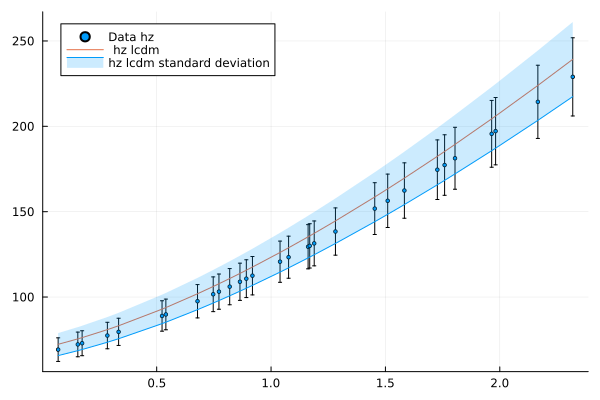

In [19]:
plot(fakedatahz.z, fakedatahz.data, yerr=hz_err, label="Data hz", ms=2, seriestype=:scatter)
plot!(fakedatahz.z, vec(hz_lcdm_m), label=" hz lcdm")
plot!(fakedatahz.z, vec(hz_lcdm_m .- hz_lcdm_s),  fillrange = vec(hz_lcdm_m .+ hz_lcdm_s), fillalpha=0.2, c=1, label="hz lcdm standard deviation")

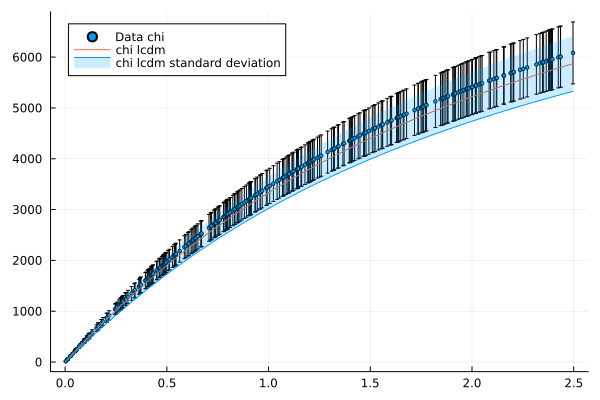

In [20]:
plot(fakedatadm.z, fakedatadm.data, yerr=dm_err, label="Data chi", ms=2, seriestype=:scatter)
plot!(fakedatadm.z, vec(dm_lcdm_m), label="chi lcdm")
plot!(fakedatadm.z, vec(dm_lcdm_m .- dm_lcdm_s),  fillrange = vec(dm_lcdm_m .+ dm_lcdm_s), fillalpha=0.2, c=1, label="chi lcdm standard deviation")

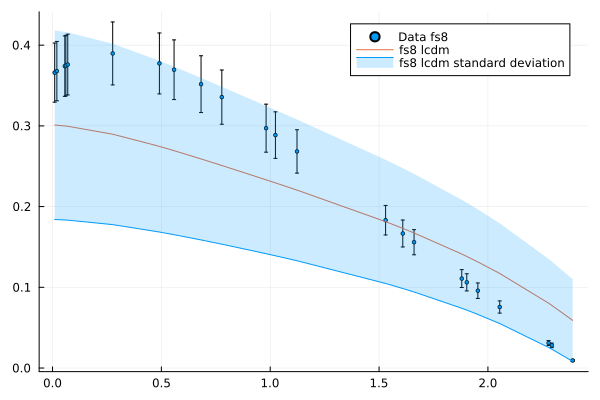

In [21]:
plot(fakedatafs8.z, fakedatafs8.data, yerr=fs8_err, label="Data fs8", ms=2, seriestype=:scatter)
plot!(fakedatafs8.z, vec(fs8_lcdm_m), label="fs8 lcdm")
plot!(fakedatafs8.z, vec(fs8_lcdm_m .- fs8_lcdm_s),  fillrange = vec(fs8_lcdm_m .+ fs8_lcdm_s), fillalpha=0.2, c=1, label="fs8 lcdm standard deviation")

## GP modelling - priors

In [22]:
zlat = range(0, 3.0, length=30); # latent variable space
z_integ = range(0, 3.0, length=500); # integral variable space

In [23]:
# preset parameter values
omegam = cosmo1.cpar.Ωm
s8 = cosmo1.cpar.σ8
hc = cosmo1.cpar.h
omegab = cosmo1.cpar.Ωb

0.05

In [24]:
function model_latent_GP(eta, l, v; sigma_8=cosmo1.cpar.σ8,
                         x=zlat, z=z_obs, data_cov=covariance_obs)
    # Dimensions of predictors .
    kernel = sqexp_cov_fn(x; eta=eta, l=l)
    cpar = CosmoPar(Ωm=cosmo1.cpar.Ωm,  Ωb=cosmo1.cpar.Ωb, h=cosmo1.cpar.h, σ8=sigma_8)
    mean_ex = Ez(cpar, x)
    # a latent GP is carried out using a Wiener filter
    ex = latent_GP(mean_ex, v, kernel)
    # transforms hx from x space to z space
    ez =  conditional(x, z, ex, sqexp_cov_fn;
                     eta=eta, l=l)
    return ex, ez
end

model_latent_GP (generic function with 1 method)

hx is the GP realisation of the hubble parameter. hz transforms hx from the latent space to another parameter space (integral or observation).

In [25]:
N_samples = 100
# data parameter space conditional
exs1=zeros(N_samples, 30) #latent variable chain
ezs1=zeros(N_samples, length(z_obs)) #observed variable chain
# pick 100 random hyperparameter combinations, and compute the GP realisation of them in both latent and conditional space.
for i in 1:N_samples
    v = rand(MvNormal(zeros(length(zlat)), ones(length(zlat))))
    exs1[i, :], ezs1[i, :] = model_latent_GP(20, 0.3, v)
end
y_m1, y_s1 = mean(ezs1, dims=1), std(ezs1, dims=1); #observed space
gp_m1, gp_s1 = mean(exs1, dims=1), std(exs1, dims=1); #latent space


In [26]:
# integral parameter space conditional
exs2=zeros(N_samples, length(zlat))
ezs2=zeros(N_samples, length(z_integ))
hz_pr=zeros(N_samples, length(z_integ))
dm_pr=zeros(N_samples, length(z_integ))
fs8_pr=zeros(N_samples, length(z_integ))

for i in 1:N_samples
    v = rand(MvNormal(zeros(length(zlat)), ones(length(zlat))))
    h_pr = rand(Uniform(0.6, 0.8))
    s8_pr = rand(Uniform(0.7, 0.9))
    omegam_pr = rand(Uniform(0.25,0.35))
    exs2[i, :], ezs2[i, :] = model_latent_GP(20, 0.3, v; z=z_integ)
    hz_pr[i, :] = hubble_param(z_integ, h_pr, ezs2[i, :])
    dm_pr[i, :] = comoving_d(z_integ, h_pr, ezs2[i, :])
    fs8_pr[i, :] = get_growth3(z_integ, omegam_pr, s8_pr, h_pr, eltype(ezs2[i, :]), ezs2[i, :])
end

y_m2, y_s2 = mean(ezs2, dims=1), std(ezs2, dims=1); #integral space
hz_m2, hz_s2 = mean(hz_pr, dims=1), std(hz_pr, dims=1); 
chi_m2, chi_s2 = mean(dm_pr, dims=1), std(dm_pr, dims=1);
fs8_m2, fs8_s2 = mean(fs8_pr, dims=1), std(fs8_pr, dims=1);
gp_m2, gp_s2 = mean(exs2, dims=1), std(exs2, dims=1); #latent space

In [27]:
# prior model predictions
hz_itp2 = LinearInterpolation(z_integ, vec(hz_m2), extrapolation_bc=Line());
dm_itp2 = LinearInterpolation(z_integ, vec(chi_m2), extrapolation_bc=Line());
fs8_itp2 = LinearInterpolation(z_integ, vec(fs8_m2), extrapolation_bc=Line());

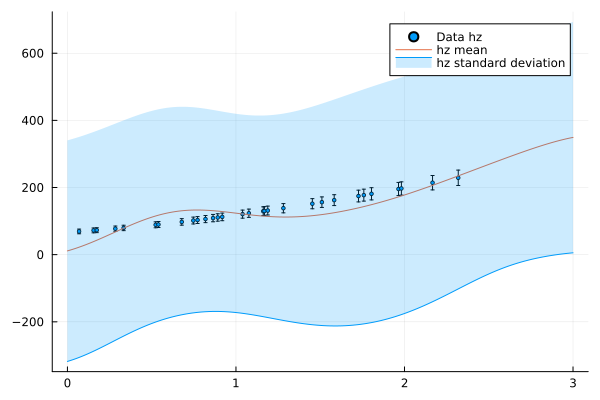

In [28]:
# integral space hz plot
plot(fakedatahz.z, fakedatahz.data, yerr=hz_err, label="Data hz", ms=2, seriestype=:scatter)
plot!(z_integ, vec(hz_m2), label="hz mean")
plot!(z_integ, vec(hz_m2 .- hz_s2),  fillrange = vec(hz_m2 .+ hz_s2), fillalpha=0.2, c=1, label="hz standard deviation")

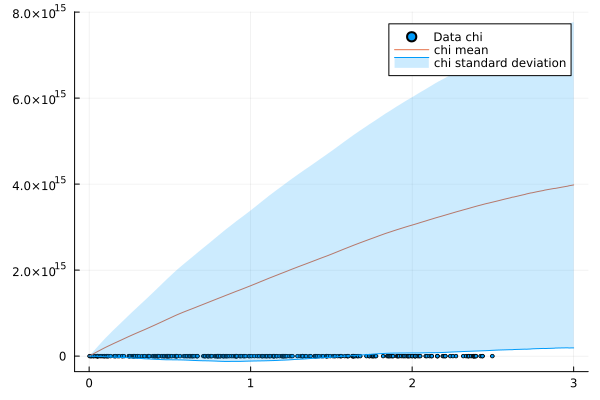

In [29]:
# plotting chi data 
plot(fakedatadm.z, fakedatadm.data, yerr=dm_err, label="Data chi", ms=2, seriestype=:scatter)
plot!(z_integ, vec(chi_m2), label="chi mean")
plot!(z_integ, vec(chi_m2 .- chi_s2),  fillrange = vec(chi_m2 .+ chi_s2), fillalpha=0.2, c=1, label="chi standard deviation")

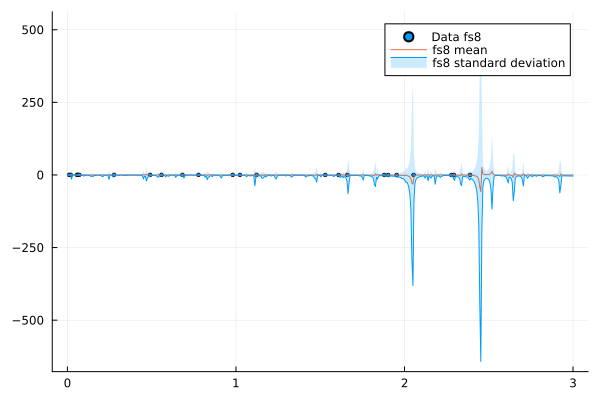

In [30]:
# plotting fs8 data 
plot(fakedatafs8.z, fakedatafs8.data, yerr=fs8_err, label="Data fs8", ms=2, seriestype=:scatter)
plot!(z_integ, vec(fs8_m2), label="fs8 mean")
plot!(z_integ, vec(fs8_m2 .- fs8_s2),  fillrange = vec(fs8_m2 .+ fs8_s2), fillalpha=0.2, c=1, label="fs8 standard deviation")

## GP modelling - posteriors

In [31]:
@model function stats_model(y; int_grid=z_integ, X=zlat, data_x=z_obs, data_cov=covariance_obs)
    # Priors, parameters
    eta2 = 20
    l2 = 0.3
    v_po ~ MvNormal(zeros(length(X)), ones(length(X)))
    omegam_po ~ Uniform(0.25, 0.35)
    s8_po ~ Uniform(0.7, 0.9)
    h_po ~ Uniform(0.6, 0.8)
    kernel = sqexp_cov_fn(X, eta=eta2, l=l2)
    cpar = CosmoPar(Ωm=cosmo1.cpar.Ωm, Ωb=cosmo1.cpar.Ωb, h=cosmo1.cpar.h, σ8=s8_po)
    mean_ez = Ez(cpar, X)
    ez_latent = latent_GP(mean_ez, v_po, kernel)
    ez_gp = conditional(X, int_grid, ez_latent, sqexp_cov_fn; eta=eta2, l=l2) # converting from latent space to integral space
    # sampling over parameters
    mean_hz = hubble_param(int_grid, h_po, ez_gp);
    chi = comoving_d(int_grid, h_po, ez_gp);
    fs8 = get_growth3(int_grid, omegam_po, s8_po, h_po, eltype(ez_gp), ez_gp);

    hz_interp = linear_interpolation(int_grid, mean_hz, extrapolation_bc=Line())
    chi_interp = linear_interpolation(int_grid, chi, extrapolation_bc=Line())
    fs8_interp = linear_interpolation(int_grid, fs8, extrapolation_bc=Line())

    hdata := hz_interp(fakedatahz.z)
    chidata := chi_interp(fakedatadm.z)
    fs8data := fs8_interp(fakedatafs8.z)
    datay = [hdata;chidata;fs8data]

    y = MvNormal(datay, data_cov)

end

stats_model (generic function with 2 methods)

In [32]:
chain_gp = sample(stats_model(data_obs), NUTS(20, 0.65), 100)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /Users/vis/.julia/packages/Turing/QN7BL/src/mcmc/hmc.jl:212
Sampling   1%|▍                                         |  ETA: 0:41:34
Sampling   2%|▊                                         |  ETA: 0:20:48
Sampling   2%|█                                         |  ETA: 0:14:07
Sampling   3%|█▍                                        |  ETA: 0:11:03
Sampling   4%|█▊                                        |  ETA: 0:09:01
Sampling   5%|██▏                                       |  ETA: 0:07:49
Sampling   6%|██▌                                       |  ETA: 0:06:52
Sampling   7%|██▊                                       |  ETA: 0:06:08
Sampling   8%|███▏                                      |  ETA: 0:05:29
Sampling   8%|███▌                                      |  ETA: 0:04:58
Sampling   9%|███▉                                      |  ETA: 0:05:00
Sampling  10%|█

Chains MCMC chain (100×398×1 Array{Float64, 3}):

Iterations        = 21:1:120
Number of chains  = 1
Samples per chain = 100
Wall duration     = 123.47 seconds
Compute duration  = 123.47 seconds
parameters        = v_po[1], v_po[2], v_po[3], v_po[4], v_po[5], v_po[6], v_po[7], v_po[8], v_po[9], v_po[10], v_po[11], v_po[12], v_po[13], v_po[14], v_po[15], v_po[16], v_po[17], v_po[18], v_po[19], v_po[20], v_po[21], v_po[22], v_po[23], v_po[24], v_po[25], v_po[26], v_po[27], v_po[28], v_po[29], v_po[30], omegam_po, s8_po, h_po, hdata[1], hdata[2], hdata[3], hdata[4], hdata[5], hdata[6], hdata[7], hdata[8], hdata[9], hdata[10], hdata[11], hdata[12], hdata[13], hdata[14], hdata[15], hdata[16], hdata[17], hdata[18], hdata[19], hdata[20], hdata[21], hdata[22], hdata[23], hdata[24], hdata[25], hdata[26], hdata[27], hdata[28], hdata[29], hdata[30], chidata[1], chidata[2], chidata[3], chidata[4], chidata[5], chidata[6], chidata[7], chidata[8], chidata[9], chidata[10], chidata[11], chidata[12], ch

In [33]:
hdata_p = group(chain_gp, :hdata).value.data[:,:,1];
chidata_p =  group(chain_gp, :chidata).value.data[:,:,1];
fs8data_p =  group(chain_gp, :fs8data).value.data[:,:,1];

In [34]:
v_p = group(chain_gp, :v_po).value.data[:, :, 1];
omegam_p = group(chain_gp, :omegam_po).value.data[:, :, 1];
s8_p = group(chain_gp, :s8_po).value.data[:, :, 1];

In [35]:
hpmean, hps = mean(hdata_p, dims=1), std(hdata_p, dims=1);
chipmean, chips = mean(chidata_p, dims=1), std(chidata_p, dims=1);
fs8pmean, fs8ps = mean(fs8data_p, dims=1), std(fs8data_p, dims=1);

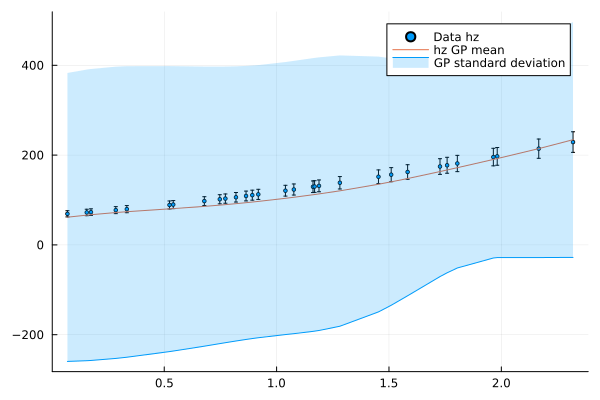

In [36]:
plot(fakedatahz.z, fakedatahz.data, yerr=hz_err, label="Data hz", ms=2, seriestype=:scatter)
plot!(fakedatahz.z, vec(hpmean), label="hz GP mean")
plot!(fakedatahz.z, vec(hpmean .- hps),  fillrange = vec(hpmean .+ hps), fillalpha=0.2, c=1, label="GP standard deviation")

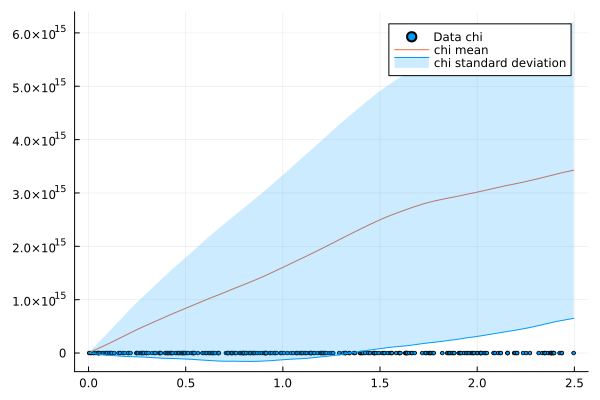

In [37]:
plot(fakedatadm.z, fakedatadm.data, yerr=dm_err, label="Data chi", ms=2, seriestype=:scatter)
plot!(fakedatadm.z, vec(chipmean), label="chi mean")
plot!(fakedatadm.z, vec(chipmean .- chips),  fillrange = vec(chipmean .+ chips), fillalpha=0.2, c=1, label="chi standard deviation")

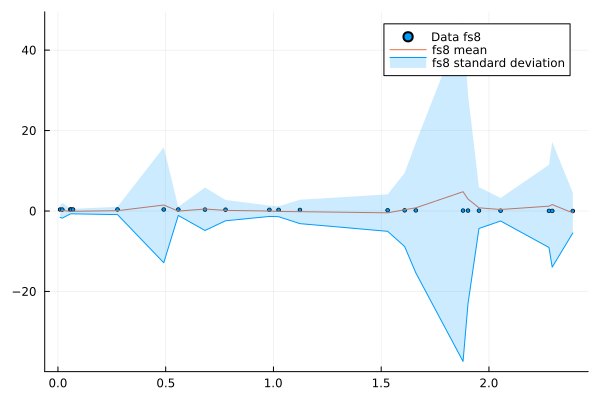

In [38]:
plot(fakedatafs8.z, fakedatafs8.data, yerr=fs8_err, label="Data fs8", ms=2, seriestype=:scatter)
plot!(fakedatafs8.z, vec(fs8pmean), label="fs8 mean")
plot!(fakedatafs8.z, vec(fs8pmean .- fs8ps),  fillrange = vec(fs8pmean .+ fs8ps), fillalpha=0.2, c=1, label="fs8 standard deviation")